## randomized functions

In [1]:
import numpy as np

In [2]:
def standardize_imgs(imgs):
    assert len(imgs.size()) == 4
    for i in range(imgs.size(0)):
        tmp = imgs[i].view(3, -1)
        tmp_mean = tmp.mean(dim=1).numpy()
        tmp_var = np.maximum(tmp.std(dim=1).numpy(), 1.0 / 28.0 / 28.0)

        imgs[i] = (imgs[i] - torch.FloatTensor(tmp_mean).view(3, 1, 1)) / torch.FloatTensor(tmp_var).view(3,1,1)
    return imgs

## CNN without pooling

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

class CNN(nn.Module):
    def __init__(self, nb):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, nb, 3)
        #self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(nb, nb, 3)
        self.conv3 = nn.Conv2d(nb, nb, 3)
        self.conv4 = nn.Conv2d(nb, nb, 3)
        self.conv5 = nn.Conv2d(nb, nb, 3)
        #self.fc1 = nn.Linear(nb * 18 * 18, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        self.fc = nn.Linear(nb * 18 * 18, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        #print(x.size())
        x = x.view(-1, nb * 18 * 18)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        x = self.fc(x)
        return x

## import cifar 10 dataset

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [5]:
transform = transforms.Compose(
    [transforms.CenterCrop(28),
     transforms.ToTensor()
     ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
pixel_mode = "true_pixel"
label_mode = "true_label"

criterion = nn.CrossEntropyLoss()

def train(epoch, starting_step, optimizer, net):
    # print("\nepoch %d" %epoch)
    
    total_loss = 0
    total_samples = 0
    total_corrects = 0
#     print("starting_step is ",starting_step)
    for i, (imgs, labels) in enumerate(trainloader):
        imgs = standardize_imgs(imgs)

        if use_cuda:
            imgs = Variable(imgs).cuda()
            labels = Variable(labels).cuda()
        else:
            imgs = Variable(imgs)
            labels = Variable(labels)
            
        logits = net(imgs)
        step_loss = criterion(logits, labels)
        optimizer.zero_grad()
        step_loss.backward()
        optimizer.step()       
        
        batch_size = logits.size(0)
        _, preds = torch.max(logits, 1)
        total_samples += len(labels)
        step_corrects = torch.sum(preds.data == labels.data)
        total_corrects += step_corrects
        total_loss += step_loss.data[0]
    
    train_acc = total_corrects * 1. / total_samples
    total_loss = total_loss * 1. / total_samples
            
    return  starting_step + i, train_acc, total_loss

def test(net):
  
    total_loss = 0
    total_samples = 0
    total_corrects = 0
#     print("starting_step is ",starting_step)
    for i, (imgs, labels) in enumerate(testloader):
        imgs = standardize_imgs(imgs)

        if use_cuda:
            imgs = Variable(imgs).cuda()
            labels = Variable(labels).cuda()
        else:
            imgs = Variable(imgs)
            labels = Variable(labels)
            
        logits = net(imgs)
        step_loss = criterion(logits, labels)
             
        batch_size = logits.size(0)
        _, preds = torch.max(logits, 1)
        total_samples += len(labels)
        step_corrects = torch.sum(preds.data == labels.data)
        total_corrects += step_corrects
        
        total_loss += step_loss.data[0]

    total_acc = total_corrects * 1.0 / total_samples
    total_loss = total_loss  / total_samples   
        
    print("test_acc %f, test_loss %f" %(total_acc, total_loss))
    return total_acc, total_loss

        
    

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

use_cuda = True
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

exp_dicts = {}
for nb in [2,4,8,16,32,48,64,80,96,112,128,144,160,176,192,208,224,240,256]:
    exp_dict = {}
    net = CNN(nb)
    if use_cuda: net = net.cuda()
    print('nb_param:', count_parameters(net))
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    
    starting_step = 0 
    for epoch in range(70):
        total_step, train_acc, train_loss = train(epoch, starting_step, optimizer, net)
        print("epoch %d, train_acc %f, train_loss %f" %(epoch, train_acc, train_loss))
        if train_acc == 1.0 or train_loss == 0.0:
            break
        starting_step  = total_step + 1
    
    test_acc, test_loss = test(net)
    exp_dict['train_acc'] = train_acc
    exp_dict['train_loss'] = train_loss
    exp_dict['test_acc'] = test_acc
    exp_dict['test_loss'] = test_loss
    exp_dicts[count_parameters(net)] = exp_dict
    

In [9]:
np.save('exps_cnn.npy', exp_dicts)

In [11]:
exp_dicts = np.load('exps_cnn.npy').item()
x_value = []
y_value_train_error = []
y_value_train_loss = []
y_value_test_error = []
y_value_test_loss = []
for key in exp_dicts.keys():
    x_value.append(key)
    y_value_train_error.append(1.0-exp_dicts[key]['train_acc'])
    y_value_train_loss.append(exp_dicts[key]['train_loss'])
    y_value_test_error.append(1.0-exp_dicts[key]['test_acc'])
    y_value_test_loss.append(exp_dicts[key]['test_loss'])

print('x_value',x_value)
print('y_value_train_error',y_value_train_error)
print('y_value_train_loss',y_value_train_loss)
print('y_value_test_error',y_value_test_error)
print('y_value_test_loss',y_value_test_loss)

x_value [6698, 13674, 28490, 61578, 141578, 240010, 356874, 492170, 645898, 818058, 1008650, 1217674, 1445130, 1691018, 1955338, 2238090, 2539274, 2858890, 3196938]
y_value_train_error [0.64558, 0.48448, 0.37470000000000003, 0.22716000000000003, 0.10089999999999999, 0.06332000000000004, 0.0343, 0.01876, 0.01088, 0.009539999999999993, 0.006260000000000043, 0.0039000000000000146, 0.0, 0.005959999999999965, 0.0, 0.0, 0.0025800000000000267, 0.0, 0.0]
y_value_train_loss [0.01787216610431671, 0.013857135667800903, 0.010654593873023987, 0.006350104501843453, 0.0031806916761398314, 0.0023525745975598693, 0.0012831273317080922, 0.0006611800406558905, 0.0003449480868674436, 0.000310132830426719, 0.00019234023179473298, 0.0001206357635934546, 3.431047429251066e-07, 0.00018665127469448634, 5.006074894276935e-07, 5.140844344759898e-07, 8.36837542289868e-05, 2.9928951184615473e-07, 3.8602790771392394e-07]
y_value_test_error [0.6921999999999999, 0.5475, 0.5407, 0.45809999999999995, 0.4072, 0.37060000

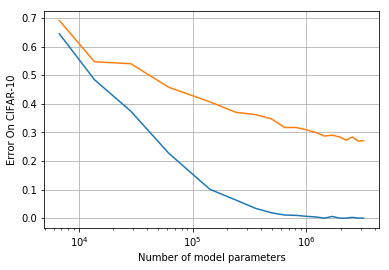

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.semilogx(x_value, y_value_train_error)
plt.semilogx(x_value, y_value_test_error)

plt.xlabel('Number of model parameters')
plt.ylabel('Error On CIFAR-10')
plt.grid(True)
#plt.savefig("test.png")
plt.show()

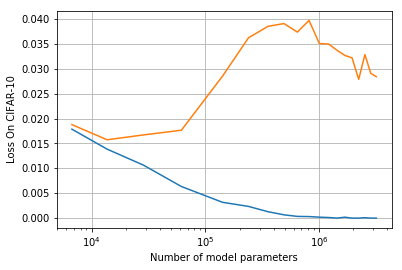

In [13]:
plt.semilogx(x_value, y_value_train_loss)
plt.semilogx(x_value, y_value_test_loss)

plt.xlabel('Number of model parameters')
plt.ylabel('Loss On CIFAR-10')
plt.grid(True)
#plt.savefig("test.png")
plt.show()